In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, average_precision_score
import shap
import matplotlib.pylab as pl

# print the JS visualization code to the notebook
shap.initjs()

In [2]:
def load_and_prepare_data(file_name):
    """Load data from a CSV file and prepare it for modeling."""
    data = pd.read_csv(file_name)
    data.drop(columns=['text', 'cluster', 'named_entities', 'Unnamed: 0'], inplace=True)  # Drop non-numeric or unnecessary columns
    X = data.drop(columns=['performance'])
    y = data['performance']
    return X, y

def train_and_evaluate(X, y):
    """Train the model and evaluate it on the test set, and calculate feature importances."""
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    feature_importances = model.feature_importances_
    return accuracy, report, feature_importances, model, X_test

def summarize_results(i, accuracy, report):
    """Summarize results for output, capturing metrics for both class 0 and class 1."""
    # Extract metrics for each class from the classification report
    class_0_metrics = report.get('0', {})
    class_1_metrics = report.get('1', {})

    return {
        'cluster': i,
        'overall_accuracy': accuracy,  # Overall accuracy is included once
        'precision_0': class_0_metrics.get('precision', 0),
        'recall_0': class_0_metrics.get('recall', 0),
        'f1-score_0': class_0_metrics.get('f1-score', 0),
        'support_0': class_0_metrics.get('support', 0),
        'precision_1': class_1_metrics.get('precision', 0),
        'recall_1': class_1_metrics.get('recall', 0),
        'f1-score_1': class_1_metrics.get('f1-score', 0),
        'support_1': class_1_metrics.get('support', 0)
    }

def collect_feature_importances(X_columns, feature_importances, cluster_id):
    """Collect feature importances into a single row for each cluster."""
    # Create a dictionary initializing with the cluster id
    feature_importance_dict = {'cluster': cluster_id}
    # Update the dictionary with feature importances
    feature_importance_dict.update({
        f'{feature}': importance for feature, importance in zip(X_columns, feature_importances)
    })
    return feature_importance_dict

In [3]:
summary_results = []
all_feature_importances = []
for i in range(1):  # Loop from 0_data.csv to 19_data.csv
    file_name = f'clusters csv\\{i}_data.csv'
    X, y = load_and_prepare_data(file_name)
    accuracy, report, feature_importances, model, X_test = train_and_evaluate(X, y)
    result = summarize_results(i, accuracy, report)
    summary_results.append(result)
    # Collect feature importances into a single dictionary for each cluster
    feature_importance_dict = collect_feature_importances(X.columns, feature_importances, i)
    all_feature_importances.append(feature_importance_dict)

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    shap.force_plot(explainer.expected_value, shap_values[0, :], X.columns)

                               Feature  Correlation
1                  flesch_reading_ease     0.902886
9                              Yelling    -0.848179
8      sentence info__complex_words_dc     0.829206
10                       Embarrassment    -0.809318
16                        Consequences    -0.797823
11                           Passenger     0.784490
14                            Reaction    -0.773499
15                             Control     0.750400
5                sentiment_score_range    -0.742597
7   readability grades__DaleChallIndex     0.740412


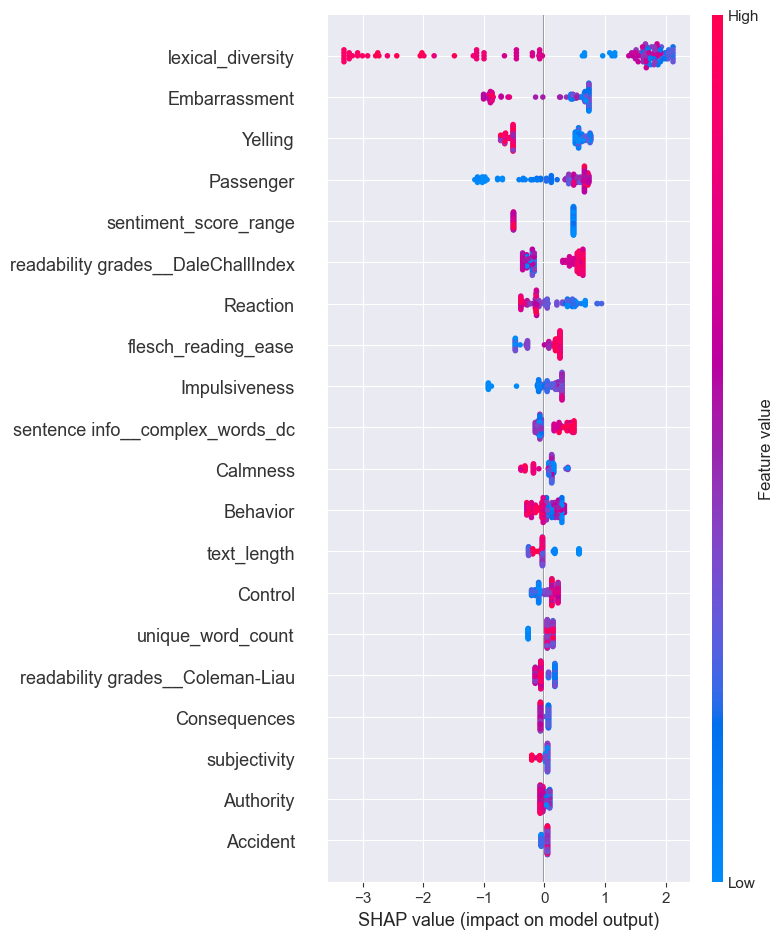

In [79]:
summary_results = []
all_feature_importances = []
file_name = f'clusters csv\\7_data.csv'
#file_name = f'full_dataset_feature_extraction_09-05.csv'
X, y = load_and_prepare_data(file_name)
accuracy, report, feature_importances, model, X_test = train_and_evaluate(X, y)
result = summarize_results(i, accuracy, report)
summary_results.append(result)
# Collect feature importances into a single dictionary for each cluster
feature_importance_dict = collect_feature_importances(X.columns, feature_importances, i)
all_feature_importances.append(feature_importance_dict)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap_df = pd.DataFrame(shap_values, columns=X.columns)

# Calculate mean absolute SHAP values for each feature
mean_abs_shap = np.abs(shap_values).mean(axis=0)
shap_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'SHAP_Importance': mean_abs_shap
})

# Filter features with SHAP importance above 0.01
important_features = shap_importance_df[shap_importance_df['SHAP_Importance'] > 0.05]['Feature']

# Calculate correlations only for important features
correlations = {feature: np.corrcoef(X[feature], shap_df[feature])[0, 1] for feature in important_features}
correlation_df = pd.DataFrame(correlations.items(), columns=['Feature', 'Correlation'])

# Sort by the absolute value of the correlation and get the top 10
top_10_correlations = correlation_df.reindex(correlation_df['Correlation'].abs().sort_values(ascending=False).index).head(10)
print(top_10_correlations)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X)

In [62]:
shap.force_plot(explainer.expected_value, shap_values[3, :], X.columns)

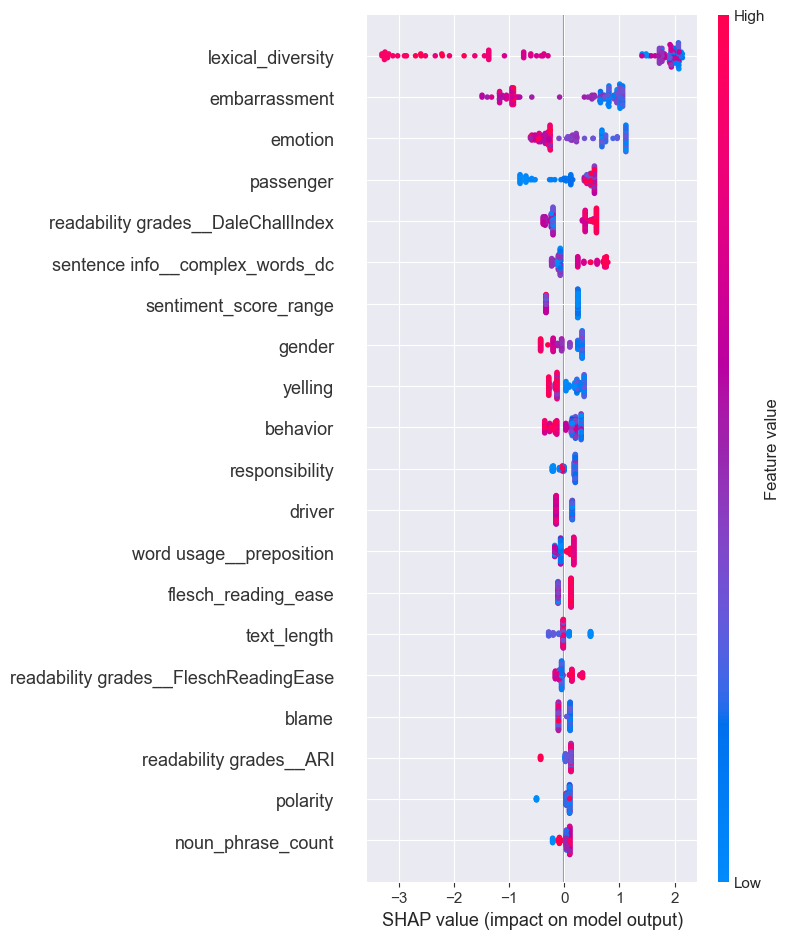

In [63]:
shap.summary_plot(shap_values, X)

In [34]:
# Select a sample index
sample_index = 4

# Calculate SHAP values for the selected sample while maintaining DataFrame structure
shap_values_single = explainer.shap_values(X_test.iloc[[sample_index]])

# Generate the force plot for class 0
# - `explainer.expected_value[0]` for the expected value of class 0
# - `shap_values_single[0][0]` to access the SHAP values for class 0 of the selected sample
shap.force_plot(
    explainer.expected_value,      # Base value (scalar)
    shap_values_single[0],         # SHAP values for the sample (array)
    X_test.iloc[sample_index]      # Feature values for the sample
)

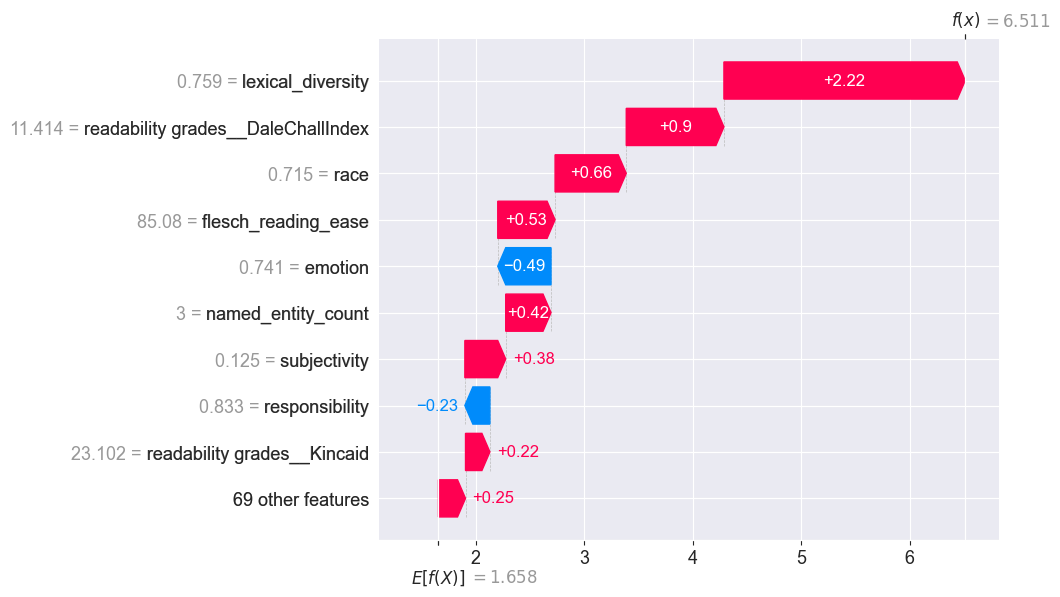

In [49]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X)
shap.plots.waterfall(shap_values[4])

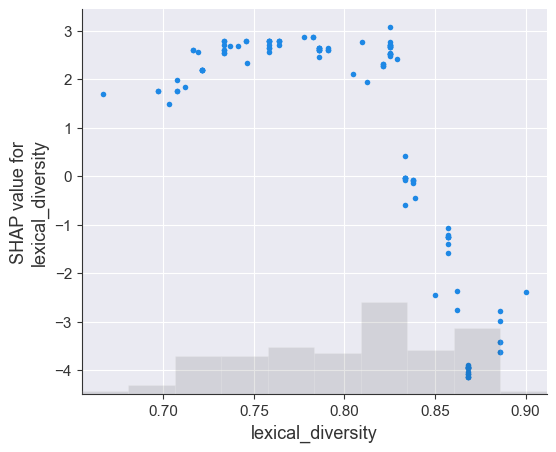

In [9]:
shap.plots.scatter(shap_values[:,"lexical_diversity"])

In [50]:
shap.plots.force(shap_values)

In [11]:
sample_index = 0
shap_values_single = explainer.shap_values(X_test.iloc[[sample_index]])

print("Expected Value:", explainer.expected_value)
print("Type of Expected Value:", type(explainer.expected_value))
print("Shape of SHAP values for single sample:", np.array(shap_values_single).shape)
print("Content of SHAP values for single sample:", shap_values_single)

Expected Value: 1.6450632
Type of Expected Value: <class 'numpy.float32'>
Shape of SHAP values for single sample: (1, 58)
Content of SHAP values for single sample: [[ 0.01342568  0.20748511  0.73948634 -0.33274665 -4.1371365  -0.6099911
   0.          0.         -0.5398114   0.00973137  0.13662145  0.
   0.         -0.2887144   0.          0.          0.          0.
   0.          0.          0.02126392  0.          0.13060969  0.01625139
  -0.33415863 -0.3942599   0.          0.          0.         -0.01624211
  -0.4347707   0.         -0.10625888  0.          0.         -0.05945476
   0.          0.          0.          0.          0.          0.
   0.          0.         -0.18523416 -0.21549237  0.          0.
  -0.11294983  0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]]


In [12]:
X_test.iloc[sample_index]

polarity                                    0.000000
subjectivity                                0.000000
flesch_reading_ease                        87.210000
syntactic_complexity                       10.500000
lexical_diversity                           0.868421
text_length                               205.000000
question_marks                              1.000000
exclamation_marks                           0.000000
avg_word_length                             4.421053
unique_word_count                          33.000000
sentiment_score_range                       0.000000
noun_phrase_count                          10.000000
verb_phrase_count                           6.000000
named_entity_count                          2.000000
passive_voice_count                         0.000000
active_voice_count                          3.000000
modal_verbs_count                           0.000000
conditional_sentences_count                 0.000000
sentence_count                              4.

In [13]:
import tiktoken
enc = tiktoken.encoding_for_model("gpt-4o")
# Load your dataset
data = pd.read_csv(file_name)

# Filter data to get only the cluster you are interested in
specific_cluster_data = data['text']
def count_tokens(text, encoder):
    tokens = encoder.encode(text)
    return len(tokens)

total_tokens = sum(specific_cluster_data.apply(lambda text: count_tokens(text, enc)))
print(f"Total number of tokens in cluster 7: {total_tokens}")

Total number of tokens in cluster 7: 6420


In [14]:
def count_tokens(text, encoder):
    tokens = encoder.encode(text)
    return len(tokens)

total_tokens = []
for i in range(20):  # Loop from 0_data.csv to 19_data.csv
    file_name = f'clusters csv\\{i}_data.csv'
    data = pd.read_csv(file_name)
    cluster_text = data['text']
    cluster_tokens = sum(cluster_text.apply(lambda text: count_tokens(text, enc)))
    total_tokens.append(cluster_tokens)
    print(f"Total number of tokens in cluster {i}: {cluster_tokens}")
    
    
cost_per_mil = 5 #USD
sum_tokens = sum(total_tokens)
cost_per_run = ((sum_tokens / 1000000) * cost_per_mil)
print('=============================================================')
print(f'Total number of tokens in dataset text: {sum_tokens}')
print(f'Cost for inputting dataset to GPT-4o: {cost_per_run}$')

Total number of tokens in cluster 0: 21652
Total number of tokens in cluster 1: 2712
Total number of tokens in cluster 2: 9169
Total number of tokens in cluster 3: 6073
Total number of tokens in cluster 4: 42370
Total number of tokens in cluster 5: 5366
Total number of tokens in cluster 6: 15964
Total number of tokens in cluster 7: 6420
Total number of tokens in cluster 8: 6412
Total number of tokens in cluster 9: 11308
Total number of tokens in cluster 10: 12736
Total number of tokens in cluster 11: 12076
Total number of tokens in cluster 12: 11952
Total number of tokens in cluster 13: 3072
Total number of tokens in cluster 14: 8610
Total number of tokens in cluster 15: 3516
Total number of tokens in cluster 16: 6344
Total number of tokens in cluster 17: 9743
Total number of tokens in cluster 18: 4402
Total number of tokens in cluster 19: 5361
Total number of tokens in dataset text: 205258
Cost for inputting dataset to GPT-4o: 1.02629$


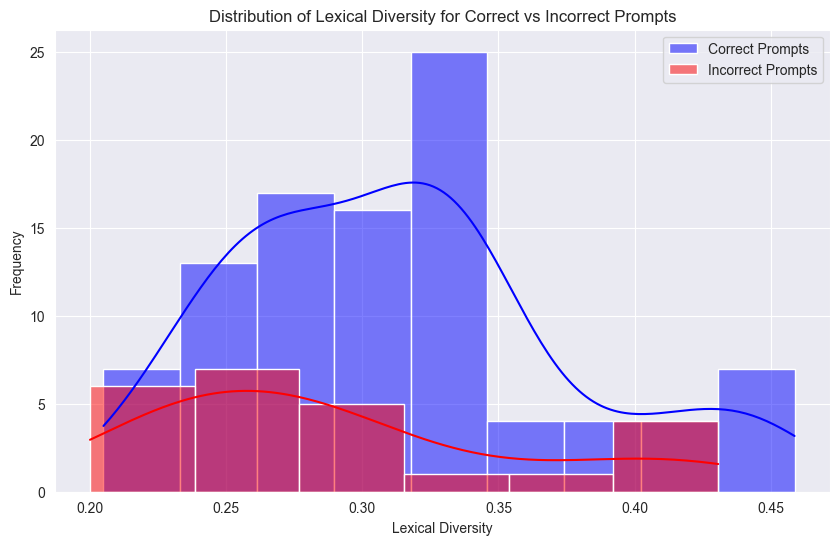

In [65]:
import pandas as pd
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data for cluster 7
file_name = 'clusters csv\\7_data.csv'
data = pd.read_csv(file_name)

# Filter by performance
# correct_diversity = data[data['performance'] == 1]['lexical_diversity']
# incorrect_diversity = data[data['performance'] == 0]['lexical_diversity']
correct_diversity = data[data['performance'] == 1]['race']
incorrect_diversity = data[data['performance'] == 0]['race']

plt.figure(figsize=(10, 6))
sns.histplot(correct_diversity, color='blue', kde=True, label='Correct Prompts')
sns.histplot(incorrect_diversity, color='red', kde=True, label='Incorrect Prompts')
plt.legend()
plt.title('Distribution of Lexical Diversity for Correct vs Incorrect Prompts')
plt.xlabel('Lexical Diversity')
plt.ylabel('Frequency')
plt.show()

In [16]:
# Perform the Mann-Whitney U Test
u_stat, p_value = mannwhitneyu(correct_diversity, incorrect_diversity, alternative='two-sided')

print(f'Mann-Whitney U statistic: {u_stat}')
print(f'P-value: {p_value}')

Mann-Whitney U statistic: 302.0
P-value: 1.984350831763871e-08


In [59]:
import pandas as pd
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import numpy as np
import nltk

# Ensure you have the necessary NLTK data files
nltk.download('punkt')
nltk.download('stopwords')

file_name = f'clusters csv\\7_data.csv'
data = pd.read_csv(file_name)
cluster_text = data['text']

# Concept words
concept_words = ["responsibility",
    "recklessness",
    "argument",
    "conflict",
    "yelling",
    "embarrassment",
    "accidents",
    "age",
    "gender",
    "race",
    "authority",
    "speeding",
    "accountability",
    "stereotypes",
    "driver",
    "passenger",
    "blame",
    "emotion",
    "confrontation",
    "behavior"]


# Tokenize and preprocess the text data
stop_words = set(stopwords.words('english'))

def preprocess(text):
    tokens = word_tokenize(text.lower())
    filtered_tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    return filtered_tokens

processed_texts = [preprocess(text) for text in cluster_text]

# Load the pre-trained Word2Vec KeyedVectors model
model_path = 'word2vec-google-news-300.model'  # Update the path to your model file
model = KeyedVectors.load(model_path)

# Save the best score for each concept word for each text
def compute_best_score(text_tokens, concept_words, model):
    best_scores = {word: float('1') for word in concept_words}
    
    for token in text_tokens:
        if token in model.key_to_index:  # Use model.key_to_index to check if token is in the model
            for concept in concept_words:
                if concept in model.key_to_index:
                    distance = model.distance(token, concept)
                    if distance < best_scores[concept]:
                        best_scores[concept] = distance
    return best_scores

# Create a list to hold the scores
scores_list = []

for text in processed_texts:
    best_scores = compute_best_score(text, concept_words, model)
    scores_list.append(best_scores)
    
# Convert the list of scores to a DataFrame
scores_df = pd.DataFrame(scores_list)

# Combine the scores with the original dataframe
result_df = pd.concat([cluster_text, scores_df], axis=1)

# Save the result to a new CSV file
result_df.to_csv('output_with_scores.csv', index=False)

print("Processing complete. The results have been saved to 'output_with_scores.csv'.")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Saar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Saar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


KeyboardInterrupt: 

In [2]:
import pandas as pd
from sentence_transformers import SentenceTransformer, util
import nltk
import numpy as np

file_name = 'clusters csv/7_data.csv'
data = pd.read_csv(file_name)
cluster_text = data['text']

# Concept words
concept_words = [
    "responsibility", "recklessness", "argument", "conflict", "yelling", "embarrassment",
    "accidents", "age", "gender", "race", "authority", "speeding", "accountability",
    "stereotypes", "driver", "passenger", "blame", "emotion", "confrontation", "behavior"
]

# Load SBERT model
model = SentenceTransformer('all-mpnet-base-v2')

# Encode concept words and text data
concept_embeddings = model.encode(concept_words, convert_to_tensor=True)
text_embeddings = model.encode(cluster_text.tolist(), convert_to_tensor=True)

# Compute cosine similarity
cosine_scores = util.pytorch_cos_sim(text_embeddings, concept_embeddings)
print(cosine_scores.shape)
# Find the highest score for each concept word for each text
def compute_best_scores(cosine_scores):
    best_scores = []
    for scores in cosine_scores:
        best_score = {concept_words[i]: scores[i].item() for i in range(len(concept_words))}
        best_scores.append(best_score)
    return best_scores

# Create a list to hold the scores
scores_list = compute_best_scores(cosine_scores)

# Convert the list of scores to a DataFrame
scores_df = pd.DataFrame(scores_list)

# Combine the scores with the original dataframe
result_df = pd.concat([data, scores_df], axis=1)

# Save the result to a new CSV file
result_df.to_csv('output_with_scores.csv', index=False)

print("Processing complete. The results have been saved to 'output_with_scores.csv'.")


D:\FinalProject\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


torch.Size([121, 20])
Processing complete. The results have been saved to 'output_with_scores.csv'.
